In [113]:
import requests
from myconfig import *
import time
import pandas as pd
import numpy as np
import ast
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.metrics import silhouette_score
import seaborn as sns
import joblib

In [26]:
response = requests.get(f"https://rawg.io/api/games?key={rawg_api_key}&page_size=40&token=") 
response.status_code

200

In [27]:
response.json().keys()

dict_keys(['count', 'next', 'previous', 'results', 'seo_title', 'seo_description', 'seo_keywords', 'seo_h1', 'noindex', 'nofollow', 'description', 'filters', 'nofollow_collections'])

In [28]:
print(response.json()["next"])
print(response.json()["count"])
print(len(response.json()["results"]))
print(response.json()["results"][4])

https://api.rawg.io/api/games?key=caaf4a3eaa414efc8b8104222607204c&page=2&page_size=40&token=
865564
40
{'id': 5286, 'slug': 'tomb-raider', 'name': 'Tomb Raider (2013)', 'released': '2013-03-05', 'tba': False, 'background_image': 'https://media.rawg.io/media/games/021/021c4e21a1824d2526f925eff6324653.jpg', 'rating': 4.05, 'rating_top': 4, 'ratings': [{'id': 4, 'title': 'recommended', 'count': 2356, 'percent': 60.53}, {'id': 5, 'title': 'exceptional', 'count': 992, 'percent': 25.49}, {'id': 3, 'title': 'meh', 'count': 425, 'percent': 10.92}, {'id': 1, 'title': 'skip', 'count': 119, 'percent': 3.06}], 'ratings_count': 3863, 'reviews_text_count': 14, 'added': 16297, 'added_by_status': {'yet': 674, 'owned': 10518, 'beaten': 4193, 'toplay': 263, 'dropped': 538, 'playing': 111}, 'metacritic': 86, 'playtime': 10, 'suggestions_count': 646, 'updated': '2024-03-30T18:27:33', 'user_game': None, 'reviews_count': 3892, 'saturated_color': '0f0f0f', 'dominant_color': '0f0f0f', 'platforms': [{'platfor

In [29]:
games = []
games.extend(response.json()["results"])

In [30]:
len(games)

40

In [31]:
next_pages = []

In [ ]:
next_pages.append(response.json()["next"])

In [46]:
# Retrieve a list of games
next_page = next_pages[-1]
while next_page:
    time.sleep(1)
    response = requests.get(next_page)
    
    if response.status_code == 200:
        next_page = response.json()["next"]
        next_pages.append(response.json()["next"])
        if len(response.json()["results"]) > 0:
            for game in response.json()["results"]:
                games.append(game)
        else:
            print("Response returned 0 records")
    else:
        print("Request failed with code: ",response.status_code)

KeyboardInterrupt: 

In [47]:
len(games)

110480

In [48]:
next_pages[-1]

'https://api.rawg.io/api/games?key=caaf4a3eaa414efc8b8104222607204c&page=2763&page_size=40&token='

'https://api.rawg.io/api/games?key=caaf4a3eaa414efc8b8104222607204c&page=2028&token='

In [27]:
{'id': 5286, 'slug': 'tomb-raider', 'name': 'Tomb Raider (2013)', 'released': '2013-03-05', 'tba': False, 'background_image': 'https://media.rawg.io/media/games/021/021c4e21a1824d2526f925eff6324653.jpg', 'rating': 4.05, 'rating_top': 4, 'ratings': [{'id': 4, 'title': 'recommended', 'count': 2355, 'percent': 60.52}, {'id': 5, 'title': 'exceptional', 'count': 992, 'percent': 25.49}, {'id': 3, 'title': 'meh', 'count': 425, 'percent': 10.92}, {'id': 1, 'title': 'skip', 'count': 119, 'percent': 3.06}], 'ratings_count': 3862, 'reviews_text_count': 14, 'added': 16265, 'added_by_status': {'yet': 675, 'owned': 10489, 'beaten': 4190, 'toplay': 262, 'dropped': 538, 'playing': 111}, 'metacritic': 86, 'playtime': 10, 'suggestions_count': 646, 'updated': '2024-03-30T11:12:58', 'user_game': None, 'reviews_count': 3891, 'saturated_color': '0f0f0f', 'dominant_color': '0f0f0f', 'platforms': [{'platform': {'id': 18, 'name': 'PlayStation 4', 'slug': 'playstation4', 'image': None, 'year_end': None, 'year_start': None, 'games_count': 6794, 'image_background': 'https://media.rawg.io/media/games/021/021c4e21a1824d2526f925eff6324653.jpg'}, 'released_at': '2013-03-05', 'requirements_en': None, 'requirements_ru': None}, {'platform': {'id': 5, 'name': 'macOS', 'slug': 'macos', 'image': None, 'year_end': None, 'year_start': None, 'games_count': 103627, 'image_background': 'https://media.rawg.io/media/games/b8c/b8c243eaa0fbac8115e0cdccac3f91dc.jpg'}, 'released_at': '2013-03-05', 'requirements_en': {'minimum': 'Minimum:\r\n\r\nOS: macOS 10.9.1\r\n\r\nProcessor: 2.0GHz Intel or greater\r\n\r\nMemory: 4GB\r\n\r\nGraphics: 512Mb AMD 4850, 512Mb Nvidia 650M, Intel HD4000\r\n\r\nHard Drive: 14GB'}, 'requirements_ru': None}, {'platform': {'id': 4, 'name': 'PC', 'slug': 'pc', 'image': None, 'year_end': None, 'year_start': None, 'games_count': 527451, 'image_background': 'https://media.rawg.io/media/games/bc0/bc06a29ceac58652b684deefe7d56099.jpg'}, 'released_at': '2013-03-05', 'requirements_en': {'minimum': '<strong>Minimum:</strong><br><ul class="bb_ul"><li><strong>OS:</strong>Windows XP / Windows Vista / Windows 7<br>\t</li><li><strong>Processor:</strong>1.8 GHz Processor<br>\t</li><li><strong>Memory:</strong>512 MB RAM<br>\t</li><li><strong>Graphics:</strong>3D graphics card compatible with DirectX 9<br>\t</li><li><strong>DirectX®:</strong>9.0<br>\t</li><li><strong>Hard Drive:</strong>2 GB HD space</li></ul>'}, 'requirements_ru': {'minimum': 'i486-100, 8 Мб', 'recommended': 'Pentium 166, 16 Мб'}}, {'platform': {'id': 1, 'name': 'Xbox One', 'slug': 'xbox-one', 'image': None, 'year_end': None, 'year_start': None, 'games_count': 5606, 'image_background': 'https://media.rawg.io/media/games/4a0/4a0a1316102366260e6f38fd2a9cfdce.jpg'}, 'released_at': '2013-03-05', 'requirements_en': None, 'requirements_ru': None}, {'platform': {'id': 14, 'name': 'Xbox 360', 'slug': 'xbox360', 'image': None, 'year_end': None, 'year_start': None, 'games_count': 2799, 'image_background': 'https://media.rawg.io/media/games/f46/f466571d536f2e3ea9e815ad17177501.jpg'}, 'released_at': '2013-03-05', 'requirements_en': None, 'requirements_ru': None}, {'platform': {'id': 16, 'name': 'PlayStation 3', 'slug': 'playstation3', 'image': None, 'year_end': None, 'year_start': None, 'games_count': 3167, 'image_background': 'https://media.rawg.io/media/games/20a/20aa03a10cda45239fe22d035c0ebe64.jpg'}, 'released_at': '2013-03-05', 'requirements_en': None, 'requirements_ru': None}], 'parent_platforms': [{'platform': {'id': 1, 'name': 'PC', 'slug': 'pc'}}, {'platform': {'id': 2, 'name': 'PlayStation', 'slug': 'playstation'}}, {'platform': {'id': 3, 'name': 'Xbox', 'slug': 'xbox'}}, {'platform': {'id': 5, 'name': 'Apple Macintosh', 'slug': 'mac'}}], 'genres': [{'id': 4, 'name': 'Action', 'slug': 'action', 'games_count': 178957, 'image_background': 'https://media.rawg.io/media/games/b45/b45575f34285f2c4479c9a5f719d972e.jpg'}], 'stores': [{'id': 33824, 'store': {'id': 7, 'name': 'Xbox 360 Store', 'slug': 'xbox360', 'domain': 'marketplace.xbox.com', 'games_count': 1912, 'image_background': 'https://media.rawg.io/media/games/157/15742f2f67eacff546738e1ab5c19d20.jpg'}}, {'id': 13151, 'store': {'id': 1, 'name': 'Steam', 'slug': 'steam', 'domain': 'store.steampowered.com', 'games_count': 90621, 'image_background': 'https://media.rawg.io/media/games/34b/34b1f1850a1c06fd971bc6ab3ac0ce0e.jpg'}}, {'id': 5640, 'store': {'id': 3, 'name': 'PlayStation Store', 'slug': 'playstation-store', 'domain': 'store.playstation.com', 'games_count': 7920, 'image_background': 'https://media.rawg.io/media/games/73e/73eecb8909e0c39fb246f457b5d6cbbe.jpg'}}, {'id': 218233, 'store': {'id': 8, 'name': 'Google Play', 'slug': 'google-play', 'domain': 'play.google.com', 'games_count': 17088, 'image_background': 'https://media.rawg.io/media/games/562/562553814dd54e001a541e4ee83a591c.jpg'}}, {'id': 79036, 'store': {'id': 4, 'name': 'App Store', 'slug': 'apple-appstore', 'domain': 'apps.apple.com', 'games_count': 75449, 'image_background': 'https://media.rawg.io/media/games/13a/13a528ac9cf48bbb6be5d35fe029336d.jpg'}}, {'id': 713685, 'store': {'id': 11, 'name': 'Epic Games', 'slug': 'epic-games', 'domain': 'epicgames.com', 'games_count': 1325, 'image_background': 'https://media.rawg.io/media/games/be0/be01c3d7d8795a45615da139322ca080.jpg'}}], 'clip': None, 'tags': [{'id': 31, 'name': 'Singleplayer', 'slug': 'singleplayer', 'language': 'eng', 'games_count': 219672, 'image_background': 'https://media.rawg.io/media/games/4be/4be6a6ad0364751a96229c56bf69be59.jpg'}, {'id': 7, 'name': 'Multiplayer', 'slug': 'multiplayer', 'language': 'eng', 'games_count': 37382, 'image_background': 'https://media.rawg.io/media/games/b8c/b8c243eaa0fbac8115e0cdccac3f91dc.jpg'}, {'id': 40836, 'name': 'Full controller support', 'slug': 'full-controller-support', 'language': 'eng', 'games_count': 17080, 'image_background': 'https://media.rawg.io/media/games/d58/d588947d4286e7b5e0e12e1bea7d9844.jpg'}, {'id': 13, 'name': 'Atmospheric', 'slug': 'atmospheric', 'language': 'eng', 'games_count': 32370, 'image_background': 'https://media.rawg.io/media/games/6cd/6cd653e0aaef5ff8bbd295bf4bcb12eb.jpg'}, {'id': 24, 'name': 'RPG', 'slug': 'rpg', 'language': 'eng', 'games_count': 20161, 'image_background': 'https://media.rawg.io/media/games/995/9951d9d55323d08967640f7b9ab3e342.jpg'}, {'id': 149, 'name': 'Third Person', 'slug': 'third-person', 'language': 'eng', 'games_count': 11021, 'image_background': 'https://media.rawg.io/media/games/490/49016e06ae2103881ff6373248843069.jpg'}, {'id': 6, 'name': 'Exploration', 'slug': 'exploration', 'language': 'eng', 'games_count': 22176, 'image_background': 'https://media.rawg.io/media/games/d7d/d7d33daa1892e2468cd0263d5dfc957e.jpg'}, {'id': 193, 'name': 'Classic', 'slug': 'classic', 'language': 'eng', 'games_count': 1788, 'image_background': 'https://media.rawg.io/media/games/ee3/ee3e10193aafc3230ba1cae426967d10.jpg'}, {'id': 189, 'name': 'Female Protagonist', 'slug': 'female-protagonist', 'language': 'eng', 'games_count': 12006, 'image_background': 'https://media.rawg.io/media/games/562/562553814dd54e001a541e4ee83a591c.jpg'}, {'id': 15, 'name': 'Stealth', 'slug': 'stealth', 'language': 'eng', 'games_count': 6144, 'image_background': 'https://media.rawg.io/media/games/9dd/9ddabb34840ea9227556670606cf8ea3.jpg'}, {'id': 69, 'name': 'Action-Adventure', 'slug': 'action-adventure', 'language': 'eng', 'games_count': 15766, 'image_background': 'https://media.rawg.io/media/games/c89/c89ca70716080733d03724277df2c6c7.jpg'}, {'id': 150, 'name': 'Third-Person Shooter', 'slug': 'third-person-shooter', 'language': 'eng', 'games_count': 3308, 'image_background': 'https://media.rawg.io/media/games/d82/d82990b9c67ba0d2d09d4e6fa88885a7.jpg'}, {'id': 74, 'name': 'Retro', 'slug': 'retro', 'language': 'eng', 'games_count': 41175, 'image_background': 'https://media.rawg.io/media/games/fad/fadc4be043ed07904012d47cd02671e4.jpg'}, {'id': 110, 'name': 'Cinematic', 'slug': 'cinematic', 'language': 'eng', 'games_count': 1957, 'image_background': 'https://media.rawg.io/media/games/0b3/0b34647c42271600399b93d19b10f1aa.jpg'}, {'id': 269, 'name': 'Quick-Time Events', 'slug': 'quick-time-events', 'language': 'eng', 'games_count': 561, 'image_background': 'https://media.rawg.io/media/games/8d6/8d69eb6c32ed6acfd75f82d532144993.jpg'}, {'id': 126, 'name': 'Dinosaurs', 'slug': 'dinosaurs', 'language': 'eng', 'games_count': 1697, 'image_background': 'https://media.rawg.io/media/games/838/838b3e1f39cb8e60c9287cc88607bf52.jpg'}, {'id': 306, 'name': 'Lara Croft', 'slug': 'lara-croft', 'language': 'eng', 'games_count': 14, 'image_background': 'https://media.rawg.io/media/games/e6b/e6b025951f9a72673f41c0588fb85758.jpg'}], 'esrb_rating': {'id': 4, 'name': 'Mature', 'slug': 'mature'}, 'short_screenshots': [{'id': -1, 'image': 'https://media.rawg.io/media/games/021/021c4e21a1824d2526f925eff6324653.jpg'}, {'id': 99160, 'image': 'https://media.rawg.io/media/screenshots/4f9/4f9d5efdecfb63cb99f1baa4c0ceb3bf.jpg'}, {'id': 99161, 'image': 'https://media.rawg.io/media/screenshots/80f/80f373082b2a74da3f9c3fe2b877dcd0.jpg'}, {'id': 99162, 'image': 'https://media.rawg.io/media/screenshots/a87/a8733e877f8fbe45e4a727c22a06aa2e.jpg'}, {'id': 99163, 'image': 'https://media.rawg.io/media/screenshots/3f9/3f91678c6805a76419fa4ea3a045a909.jpg'}, {'id': 99164, 'image': 'https://media.rawg.io/media/screenshots/417/4170bf07be43a8d8249193883f87f1c1.jpg'}, {'id': 99165, 'image': 'https://media.rawg.io/media/screenshots/2a4/2a4250f83ad9e959d8b4ca9376ae34ea.jpg'}]}

{'id': 5286,
 'slug': 'tomb-raider',
 'name': 'Tomb Raider (2013)',
 'released': '2013-03-05',
 'tba': False,
 'background_image': 'https://media.rawg.io/media/games/021/021c4e21a1824d2526f925eff6324653.jpg',
 'rating': 4.05,
 'rating_top': 4,
 'ratings': [{'id': 4,
   'title': 'recommended',
   'count': 2355,
   'percent': 60.52},
  {'id': 5, 'title': 'exceptional', 'count': 992, 'percent': 25.49},
  {'id': 3, 'title': 'meh', 'count': 425, 'percent': 10.92},
  {'id': 1, 'title': 'skip', 'count': 119, 'percent': 3.06}],
 'ratings_count': 3862,
 'reviews_text_count': 14,
 'added': 16265,
 'added_by_status': {'yet': 675,
  'owned': 10489,
  'beaten': 4190,
  'toplay': 262,
  'dropped': 538,
  'playing': 111},
 'metacritic': 86,
 'playtime': 10,
 'suggestions_count': 646,
 'updated': '2024-03-30T11:12:58',
 'user_game': None,
 'reviews_count': 3891,
 'saturated_color': '0f0f0f',
 'dominant_color': '0f0f0f',
 'platforms': [{'platform': {'id': 18,
    'name': 'PlayStation 4',
    'slug': 'p

In [49]:
df = pd.DataFrame(games)
df.head()

,id,slug,name,released,tba,background_image,rating,rating_top,ratings,ratings_count,reviews_text_count,added,added_by_status,metacritic,playtime,suggestions_count,updated,user_game,reviews_count,saturated_color,dominant_color,platforms,parent_platforms,genres,stores,clip,tags,esrb_rating,short_screenshots,community_rating
0,3498,grand-theft-auto-v,Grand Theft Auto V,2013-09-17,False,https://media.rawg.io/media/games/20a/20aa03a1...,4.47,5,"[{'id': 5, 'title': 'exceptional', 'count': 40...",6777,59,20664,"{'yet': 526, 'owned': 11815, 'beaten': 5888, '...",92.0,74,431,2024-04-04T09:23:28,None,6878,0f0f0f,0f0f0f,"[{'platform': {'id': 4, 'name': 'PC', 'slug': ...","[{'platform': {'id': 1, 'name': 'PC', 'slug': ...","[{'id': 4, 'name': 'Action', 'slug': 'action',...","[{'id': 290375, 'store': {'id': 3, 'name': 'Pl...",None,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}","[{'id': -1, 'image': 'https://media.rawg.io/me...",NaN
1,3328,the-witcher-3-wild-hunt,The Witcher 3: Wild Hunt,2015-05-18,False,https://media.rawg.io/media/games/618/618c2031...,4.65,5,"[{'id': 5, 'title': 'exceptional', 'count': 50...",6489,73,19980,"{'yet': 1115, 'owned': 11499, 'beaten': 4787, ...",92.0,45,675,2024-04-05T08:46:03,None,6595,0f0f0f,0f0f0f,"[{'platform': {'id': 186, 'name': 'Xbox Series...","[{'platform': {'id': 1, 'name': 'PC', 'slug': ...","[{'id': 4, 'name': 'Action', 'slug': 'action',...","[{'id': 354780, 'store': {'id': 5, 'name': 'GO...",None,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}","[{'id': -1, 'image': 'https://media.rawg.io/me...",NaN
2,4200,portal-2,Portal 2,2011-04-18,False,https://media.rawg.io/media/games/2ba/2bac0e87...,4.61,5,"[{'id': 5, 'title': 'exceptional', 'count': 39...",5615,35,18820,"{'yet': 614, 'owned': 11617, 'beaten': 5477, '...",95.0,11,550,2024-04-04T09:25:19,None,5668,0f0f0f,0f0f0f,"[{'platform': {'id': 16, 'name': 'PlayStation ...","[{'platform': {'id': 1, 'name': 'PC', 'slug': ...","[{'id': 2, 'name': 'Shooter', 'slug': 'shooter...","[{'id': 465889, 'store': {'id': 2, 'name': 'Xb...",None,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 2, 'name': 'Everyone 10+', 'slug': 'eve...","[{'id': -1, 'image': 'https://media.rawg.io/me...",NaN
3,4291,counter-strike-global-offensive,Counter-Strike: Global Offensive,2012-08-21,False,https://media.rawg.io/media/games/736/73619bd3...,3.57,4,"[{'id': 4, 'title': 'recommended', 'count': 16...",3443,26,16389,"{'yet': 262, 'owned': 12402, 'beaten': 1025, '...",81.0,65,587,2024-04-04T09:24:02,None,3478,0f0f0f,0f0f0f,"[{'platform': {'id': 4, 'name': 'PC', 'slug': ...","[{'platform': {'id': 1, 'name': 'PC', 'slug': ...","[{'id': 2, 'name': 'Shooter', 'slug': 'shooter...","[{'id': 4619, 'store': {'id': 3, 'name': 'Play...",None,"[{'id': 40847, 'name': 'Steam Achievements', '...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}","[{'id': -1, 'image': 'https://media.rawg.io/me...",NaN
4,5286,tomb-raider,Tomb Raider (2013),2013-03-05,False,https://media.rawg.io/media/games/021/021c4e21...,4.05,4,"[{'id': 4, 'title': 'recommended', 'count': 23...",3863,14,16297,"{'yet': 674, 'owned': 10518, 'beaten': 4193, '...",86.0,10,646,2024-03-30T18:27:33,None,3892,0f0f0f,0f0f0f,"[{'platform': {'id': 18, 'name': 'PlayStation ...","[{'platform': {'id': 1, 'name': 'PC', 'slug': ...","[{'id': 4, 'name': 'Action', 'slug': 'action',...","[{'id': 33824, 'store': {'id': 7, 'name': 'Xbo...",None,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}","[{'id': -1, 'image': 'https://media.rawg.io/me...",NaN


In [50]:
df.shape

(110480, 30)

In [51]:
print("shape: ",df.shape)
print(df.dtypes)
df.columns

shape:  (110480, 30)
id                      int64
slug                   object
name                   object
released               object
tba                      bool
background_image       object
rating                float64
rating_top              int64
ratings                object
ratings_count           int64
reviews_text_count      int64
added                   int64
added_by_status        object
metacritic            float64
playtime                int64
suggestions_count       int64
updated                object
user_game              object
reviews_count           int64
saturated_color        object
dominant_color         object
platforms              object
parent_platforms       object
genres                 object
stores                 object
clip                   object
tags                   object
esrb_rating            object
short_screenshots      object
community_rating      float64
dtype: object


Index(['id', 'slug', 'name', 'released', 'tba', 'background_image', 'rating',
       'rating_top', 'ratings', 'ratings_count', 'reviews_text_count', 'added',
       'added_by_status', 'metacritic', 'playtime', 'suggestions_count',
       'updated', 'user_game', 'reviews_count', 'saturated_color',
       'dominant_color', 'platforms', 'parent_platforms', 'genres', 'stores',
       'clip', 'tags', 'esrb_rating', 'short_screenshots', 'community_rating'],
      dtype='object')

In [25]:
# Export the records to a csv
#df.to_csv("games110480.csv")
# Import csv
df = pd.read_csv("games110480.csv")

In [26]:
df.columns

Index(['Unnamed: 0', 'id', 'slug', 'name', 'released', 'tba',
       'background_image', 'rating', 'rating_top', 'ratings', 'ratings_count',
       'reviews_text_count', 'added', 'added_by_status', 'metacritic',
       'playtime', 'suggestions_count', 'updated', 'user_game',
       'reviews_count', 'saturated_color', 'dominant_color', 'platforms',
       'parent_platforms', 'genres', 'stores', 'clip', 'tags', 'esrb_rating',
       'short_screenshots', 'community_rating'],
      dtype='object')

In [27]:
# Dimensionality Reduction
df.drop(["Unnamed: 0","tba","slug","id","background_image", "dominant_color", "reviews_text_count", "added", "added_by_status",
         "updated","user_game","saturated_color", "dominant_color", "short_screenshots", "parent_platforms", "stores"], axis=1, inplace=True)

In [28]:
# Filtering the data
# 1- Excluding the records without any 'ratings'
# 2- Excluding records with 'rating' value 0
df = df[(df['ratings'].str.len() > 0) & (df['rating'] > 2)]
df.reset_index(drop=True)
df.shape

(16043, 16)

In [29]:
# Changing from string to proper object
df["ratings_"] = list(map(lambda x: ast.literal_eval(x), df["ratings"]))
df.drop(["ratings"], axis=1, inplace=True)

In [30]:
# Json normalize for the dictionary 'ratings'
df_ratings = pd.json_normalize(df["ratings_"])
df_ratings.head(5)

,0,1,2,3
0,"{'id': 5, 'title': 'exceptional', 'count': 405...","{'id': 4, 'title': 'recommended', 'count': 225...","{'id': 3, 'title': 'meh', 'count': 437, 'perce...","{'id': 1, 'title': 'skip', 'count': 126, 'perc..."
1,"{'id': 5, 'title': 'exceptional', 'count': 508...","{'id': 4, 'title': 'recommended', 'count': 106...","{'id': 3, 'title': 'meh', 'count': 277, 'perce...","{'id': 1, 'title': 'skip', 'count': 167, 'perc..."
2,"{'id': 5, 'title': 'exceptional', 'count': 397...","{'id': 4, 'title': 'recommended', 'count': 141...","{'id': 3, 'title': 'meh', 'count': 153, 'perce...","{'id': 1, 'title': 'skip', 'count': 125, 'perc..."
3,"{'id': 4, 'title': 'recommended', 'count': 162...","{'id': 3, 'title': 'meh', 'count': 901, 'perce...","{'id': 5, 'title': 'exceptional', 'count': 560...","{'id': 1, 'title': 'skip', 'count': 389, 'perc..."
4,"{'id': 4, 'title': 'recommended', 'count': 235...","{'id': 5, 'title': 'exceptional', 'count': 992...","{'id': 3, 'title': 'meh', 'count': 425, 'perce...","{'id': 1, 'title': 'skip', 'count': 119, 'perc..."


In [31]:
df_ratings_zero = pd.json_normalize(df_ratings[0])
df_ratings_one = pd.json_normalize(df_ratings[1])
df_ratings_two = pd.json_normalize(df_ratings[2])
df_ratings_three = pd.json_normalize(df_ratings[3])

In [32]:
# Removing unnecessary columns for each df
df_ratings_zero.drop(["id","count"], axis=1, inplace=True)
df_ratings_one.drop(["id","count"], axis=1, inplace=True)
df_ratings_two.drop(["id","count"], axis=1, inplace=True)
df_ratings_three.drop(["id","count"], axis=1, inplace=True)
# Renaming columns
df_ratings_zero.columns = ["rating_title_0", "rating_percentage_0"]
df_ratings_one.columns = ["rating_title_1", "rating_percentage_1"]
df_ratings_two.columns = ["rating_title_2", "rating_percentage_2"]
df_ratings_three.columns = ["rating_title_3", "rating_percentage_3"]

In [33]:
# First concat
df_concat1 = pd.concat([df,df_ratings_zero,df_ratings_one,df_ratings_two,df_ratings_three], axis=1)
# Removing already normalized "ratings" column
df_concat1.drop(["ratings_"], axis=1, inplace=True)
df_concat1.head(3)

,name,released,rating,rating_top,ratings_count,metacritic,playtime,suggestions_count,reviews_count,platforms,genres,clip,tags,esrb_rating,community_rating,rating_title_0,rating_percentage_0,rating_title_1,rating_percentage_1,rating_title_2,rating_percentage_2,rating_title_3,rating_percentage_3
0,Grand Theft Auto V,2013-09-17,4.47,5.0,6777.0,92.0,74.0,431.0,6878.0,"[{'platform': {'id': 4, 'name': 'PC', 'slug': ...","[{'id': 4, 'name': 'Action', 'slug': 'action',...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,exceptional,58.99,recommended,32.83,meh,6.35,skip,1.83
1,The Witcher 3: Wild Hunt,2015-05-18,4.65,5.0,6489.0,92.0,45.0,675.0,6595.0,"[{'platform': {'id': 186, 'name': 'Xbox Series...","[{'id': 4, 'name': 'Action', 'slug': 'action',...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,exceptional,77.15,recommended,16.12,meh,4.20,skip,2.53
2,Portal 2,2011-04-18,4.61,5.0,5615.0,95.0,11.0,550.0,5668.0,"[{'platform': {'id': 16, 'name': 'PlayStation ...","[{'id': 2, 'name': 'Shooter', 'slug': 'shooter...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 2, 'name': 'Everyone 10+', 'slug': 'eve...",NaN,exceptional,70.15,recommended,24.95,meh,2.70,skip,2.21


In [34]:
# Change column "released' to datetime
df_concat1["released"] = pd.to_datetime(df_concat1['released'], format='%Y-%m-%d')

In [35]:
df_concat1.rating_title_0.value_counts()

rating_title_0
recommended    9248
meh            3117
exceptional    2390
skip           1288
Name: count, dtype: int64

In [36]:
df_concat1 = df_concat1[df_concat1["platforms"].isna() == False]
df_concat1.reset_index(drop=True)

,name,released,rating,rating_top,ratings_count,metacritic,playtime,suggestions_count,reviews_count,platforms,genres,clip,tags,esrb_rating,community_rating,rating_title_0,rating_percentage_0,rating_title_1,rating_percentage_1,rating_title_2,rating_percentage_2,rating_title_3,rating_percentage_3
0,Grand Theft Auto V,2013-09-17,4.47,5.0,6777.0,92.0,74.0,431.0,6878.0,"[{'platform': {'id': 4, 'name': 'PC', 'slug': ...","[{'id': 4, 'name': 'Action', 'slug': 'action',...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,exceptional,58.99,recommended,32.83,meh,6.35,skip,1.83
1,The Witcher 3: Wild Hunt,2015-05-18,4.65,5.0,6489.0,92.0,45.0,675.0,6595.0,"[{'platform': {'id': 186, 'name': 'Xbox Series...","[{'id': 4, 'name': 'Action', 'slug': 'action',...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,exceptional,77.15,recommended,16.12,meh,4.20,skip,2.53
2,Portal 2,2011-04-18,4.61,5.0,5615.0,95.0,11.0,550.0,5668.0,"[{'platform': {'id': 16, 'name': 'PlayStation ...","[{'id': 2, 'name': 'Shooter', 'slug': 'shooter...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 2, 'name': 'Everyone 10+', 'slug': 'eve...",NaN,exceptional,70.15,recommended,24.95,meh,2.70,skip,2.21
3,Counter-Strike: Global Offensive,2012-08-21,3.57,4.0,3443.0,81.0,65.0,587.0,3478.0,"[{'platform': {'id': 4, 'name': 'PC', 'slug': ...","[{'id': 2, 'name': 'Shooter', 'slug': 'shooter...",NaN,"[{'id': 40847, 'name': 'Steam Achievements', '...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,recommended,46.81,meh,25.91,exceptional,16.10,skip,11.18
4,Tomb Raider (2013),2013-03-05,4.05,4.0,3863.0,86.0,10.0,646.0,3892.0,"[{'platform': {'id': 18, 'name': 'PlayStation ...","[{'id': 4, 'name': 'Action', 'slug': 'action',...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,recommended,60.53,exceptional,25.49,meh,10.92,skip,3.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16038,Squid Game (itch),2019-10-07,4.43,5.0,7.0,NaN,0.0,19.0,7.0,"[{'platform': {'id': 4, 'name': 'PC', 'slug': ...",[],NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16039,Swing the Ball,2019-02-20,4.11,4.0,7.0,NaN,0.0,111.0,9.0,"[{'platform': {'id': 21, 'name': 'Android', 's...","[{'id': 40, 'name': 'Casual', 'slug': 'casual'...",NaN,"[{'id': 1069, 'name': 'ball', 'slug': 'ball', ...","{'id': 1, 'name': 'Everyone', 'slug': 'everyone'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16040,Clone Armies,2017-10-05,4.33,5.0,6.0,NaN,0.0,216.0,6.0,"[{'platform': {'id': 21, 'name': 'Android', 's...","[{'id': 4, 'name': 'Action', 'slug': 'action',...",NaN,"[{'id': 7, 'name': 'Multiplayer', 'slug': 'mul...","{'id': 2, 'name': 'Everyone 10+', 'slug': 'eve...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16041,Stay Alive - USSR,2020-05-03,4.33,5.0,4.0,NaN,0.0,236.0,6.0,"[{'platform': {'id': 4, 'name': 'PC', 'slug': ...",[],NaN,"[{'id': 17, 'name': 'Survival Horror', 'slug':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Changing from string to proper object
df_concat1["platforms_"] = list(map(lambda x: ast.literal_eval(x), df_concat1["platforms"]))
df_concat1.drop(["platforms"], axis=1, inplace=True)

In [38]:
df_platforms = pd.json_normalize(df_concat1["platforms_"])
df_platforms

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,"{'released_at': '2013-09-17', 'requirements_ru...","{'released_at': '2013-09-17', 'requirements_en...","{'released_at': '2013-09-17', 'requirements_en...","{'released_at': '2013-09-17', 'requirements_en...","{'released_at': '2013-09-17', 'requirements_en...","{'released_at': '2013-09-17', 'requirements_en...","{'released_at': '2013-09-17', 'requirements_en...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,"{'released_at': '2015-05-18', 'requirements_en...","{'released_at': '2015-05-18', 'requirements_en...","{'released_at': '2015-05-18', 'requirements_en...","{'released_at': '2015-05-18', 'requirements_en...","{'released_at': '2015-05-18', 'requirements_en...","{'released_at': '2015-05-18', 'requirements_en...","{'released_at': '2015-05-18', 'requirements_en...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,"{'released_at': '2011-04-18', 'requirements_en...","{'released_at': '2011-04-18', 'requirements_en...","{'released_at': '2011-04-18', 'requirements_en...","{'released_at': '2011-04-18', 'requirements_en...","{'released_at': '2011-04-18', 'requirements_en...","{'released_at': '2011-04-18', 'requirements_en...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,"{'released_at': '2012-08-21', 'platform.id': 4...","{'released_at': '2012-08-21', 'requirements_en...","{'released_at': '2012-08-21', 'requirements_en...","{'released_at': '2012-08-21', 'requirements_en...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,"{'released_at': '2013-03-05', 'requirements_en...","{'released_at': '2013-03-05', 'requirements_ru...","{'released_at': '2013-03-05', 'platform.id': 4...","{'released_at': '2013-03-05', 'requirements_en...","{'released_at': '2013-03-05', 'requirements_en...","{'released_at': '2013-03-05', 'requirements_en...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16038,"{'released_at': '2019-10-07', 'requirements_en...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
16039,"{'released_at': '2019-02-20', 'requirements_en...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
16040,"{'released_at': None, 'requirements_ru': None,...","{'released_at': '2017-10-05', 'requirements_ru...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
16041,"{'released_at': '2020-05-03', 'requirements_en...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [39]:
df_platforms_zero = pd.json_normalize(df_platforms[0])
df_platforms_one = pd.json_normalize(df_platforms[1])
df_platforms_two = pd.json_normalize(df_platforms[2])
df_platforms_three = pd.json_normalize(df_platforms[3])
df_platforms_four = pd.json_normalize(df_platforms[4])

In [40]:
df_platforms_zero.columns

Index(['released_at', 'requirements_ru', 'platform.id', 'platform.name',
       'platform.slug', 'platform.image', 'platform.year_end',
       'platform.year_start', 'platform.games_count',
       'platform.image_background', 'requirements_en.minimum',
       'requirements_en.recommended', 'requirements_en',
       'requirements_ru.minimum', 'requirements_ru.recommended',
       'requirements_en.devices'],
      dtype='object')

In [41]:
# Removing unnecessary columns for each df
df_platforms_zero = df_platforms_zero[['platform.name']]
df_platforms_one = df_platforms_one[['platform.name']]
df_platforms_two = df_platforms_two[['platform.name']]
df_platforms_three = df_platforms_three[['platform.name']]
df_platforms_four = df_platforms_four[['platform.name']]
# Renaming columns
df_platforms_zero.columns = ['platform_name_0']
df_platforms_one.columns = ['platform_name_1']
df_platforms_two.columns = ['platform_name_2']
df_platforms_three.columns = ['platform_name_3']
df_platforms_four.columns = ['platform_name_4']

In [42]:
# Second concat
df_concat2 = pd.concat([df_concat1,df_platforms_zero,df_platforms_one,df_platforms_two,df_platforms_three,df_platforms_four], axis=1)
# Removing already normalized "platforms" column
df_concat2.drop(["platforms_"], axis=1, inplace=True)
df_concat2.head(3)

,name,released,rating,rating_top,ratings_count,metacritic,playtime,suggestions_count,reviews_count,genres,clip,tags,esrb_rating,community_rating,rating_title_0,rating_percentage_0,rating_title_1,rating_percentage_1,rating_title_2,rating_percentage_2,rating_title_3,rating_percentage_3,platform_name_0,platform_name_1,platform_name_2,platform_name_3,platform_name_4
0,Grand Theft Auto V,2013-09-17,4.47,5.0,6777.0,92.0,74.0,431.0,6878.0,"[{'id': 4, 'name': 'Action', 'slug': 'action',...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,exceptional,58.99,recommended,32.83,meh,6.35,skip,1.83,PC,PlayStation 5,Xbox Series S/X,PlayStation 4,PlayStation 3
1,The Witcher 3: Wild Hunt,2015-05-18,4.65,5.0,6489.0,92.0,45.0,675.0,6595.0,"[{'id': 4, 'name': 'Action', 'slug': 'action',...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,exceptional,77.15,recommended,16.12,meh,4.20,skip,2.53,Xbox Series S/X,PlayStation 5,macOS,PlayStation 4,Nintendo Switch
2,Portal 2,2011-04-18,4.61,5.0,5615.0,95.0,11.0,550.0,5668.0,"[{'id': 2, 'name': 'Shooter', 'slug': 'shooter...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 2, 'name': 'Everyone 10+', 'slug': 'eve...",NaN,exceptional,70.15,recommended,24.95,meh,2.70,skip,2.21,PlayStation 3,PC,Xbox 360,Linux,macOS


In [43]:
df_concat2= df_concat2[df_concat2["genres"].isna() == False]
df_concat2.reset_index(drop=True)

,name,released,rating,rating_top,ratings_count,metacritic,playtime,suggestions_count,reviews_count,genres,clip,tags,esrb_rating,community_rating,rating_title_0,rating_percentage_0,rating_title_1,rating_percentage_1,rating_title_2,rating_percentage_2,rating_title_3,rating_percentage_3,platform_name_0,platform_name_1,platform_name_2,platform_name_3,platform_name_4
0,Grand Theft Auto V,2013-09-17,4.47,5.0,6777.0,92.0,74.0,431.0,6878.0,"[{'id': 4, 'name': 'Action', 'slug': 'action',...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,exceptional,58.99,recommended,32.83,meh,6.35,skip,1.83,PC,PlayStation 5,Xbox Series S/X,PlayStation 4,PlayStation 3
1,The Witcher 3: Wild Hunt,2015-05-18,4.65,5.0,6489.0,92.0,45.0,675.0,6595.0,"[{'id': 4, 'name': 'Action', 'slug': 'action',...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,exceptional,77.15,recommended,16.12,meh,4.20,skip,2.53,Xbox Series S/X,PlayStation 5,macOS,PlayStation 4,Nintendo Switch
2,Portal 2,2011-04-18,4.61,5.0,5615.0,95.0,11.0,550.0,5668.0,"[{'id': 2, 'name': 'Shooter', 'slug': 'shooter...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 2, 'name': 'Everyone 10+', 'slug': 'eve...",NaN,exceptional,70.15,recommended,24.95,meh,2.70,skip,2.21,PlayStation 3,PC,Xbox 360,Linux,macOS
3,Counter-Strike: Global Offensive,2012-08-21,3.57,4.0,3443.0,81.0,65.0,587.0,3478.0,"[{'id': 2, 'name': 'Shooter', 'slug': 'shooter...",NaN,"[{'id': 40847, 'name': 'Steam Achievements', '...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,recommended,46.81,meh,25.91,exceptional,16.10,skip,11.18,PC,Linux,Xbox 360,PlayStation 3,NaN
4,Tomb Raider (2013),2013-03-05,4.05,4.0,3863.0,86.0,10.0,646.0,3892.0,"[{'id': 4, 'name': 'Action', 'slug': 'action',...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,recommended,60.53,exceptional,25.49,meh,10.92,skip,3.06,PlayStation 4,macOS,PC,Xbox One,Xbox 360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16038,Squid Game (itch),2019-10-07,4.43,5.0,7.0,NaN,0.0,19.0,7.0,[],NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16039,Swing the Ball,2019-02-20,4.11,4.0,7.0,NaN,0.0,111.0,9.0,"[{'id': 40, 'name': 'Casual', 'slug': 'casual'...",NaN,"[{'id': 1069, 'name': 'ball', 'slug': 'ball', ...","{'id': 1, 'name': 'Everyone', 'slug': 'everyone'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16040,Clone Armies,2017-10-05,4.33,5.0,6.0,NaN,0.0,216.0,6.0,"[{'id': 4, 'name': 'Action', 'slug': 'action',...",NaN,"[{'id': 7, 'name': 'Multiplayer', 'slug': 'mul...","{'id': 2, 'name': 'Everyone 10+', 'slug': 'eve...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16041,Stay Alive - USSR,2020-05-03,4.33,5.0,4.0,NaN,0.0,236.0,6.0,[],NaN,"[{'id': 17, 'name': 'Survival Horror', 'slug':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# Changing from string to proper object
df_concat2["genres_"] = list(map(lambda x: ast.literal_eval(x), df_concat2["genres"]))
df_concat2.drop(["genres"], axis=1, inplace=True)

In [45]:
df_genres = pd.json_normalize(df_concat2["genres_"])
df_genres

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,"{'id': 4, 'name': 'Action', 'slug': 'action', ...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,"{'id': 4, 'name': 'Action', 'slug': 'action', ...","{'id': 5, 'name': 'RPG', 'slug': 'role-playing...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,"{'id': 2, 'name': 'Shooter', 'slug': 'shooter'...","{'id': 7, 'name': 'Puzzle', 'slug': 'puzzle', ...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,"{'id': 2, 'name': 'Shooter', 'slug': 'shooter'...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,"{'id': 4, 'name': 'Action', 'slug': 'action', ...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16038,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
16039,"{'id': 40, 'name': 'Casual', 'slug': 'casual',...","{'id': 51, 'name': 'Indie', 'slug': 'indie', '...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
16040,"{'id': 4, 'name': 'Action', 'slug': 'action', ...","{'id': 10, 'name': 'Strategy', 'slug': 'strate...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
16041,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [46]:
# Normalizing each column again
df_genres_zero = pd.json_normalize(df_genres[0])
df_genres_one = pd.json_normalize(df_genres[1])
df_genres_two = pd.json_normalize(df_genres[2])
df_genres_three = pd.json_normalize(df_genres[3])
df_genres_four = pd.json_normalize(df_genres[4])

# Removing unnecessary columns for each df
df_genres_zero = df_genres_zero[['name']]
df_genres_one = df_genres_one[['name']]
df_genres_two = df_genres_two[['name']]
df_genres_three = df_genres_three[['name']]
df_genres_four = df_genres_four[['name']]
# Renaming columns
df_genres_zero.columns = ['genre_0']
df_genres_one.columns = ['genre_1']
df_genres_two.columns = ['genre_2']
df_genres_three.columns = ['genre_3']
df_genres_four.columns = ['genre_4']

# Third concat
df_concat3 = pd.concat([df_concat2,df_genres_zero,df_genres_one,df_genres_two,df_genres_three,df_genres_four], axis=1)
# Removing already normalized "genres" column
df_concat3.drop(["genres_"], axis=1, inplace=True)
df_concat3.head(3)

,name,released,rating,rating_top,ratings_count,metacritic,playtime,suggestions_count,reviews_count,clip,tags,esrb_rating,community_rating,rating_title_0,rating_percentage_0,rating_title_1,rating_percentage_1,rating_title_2,rating_percentage_2,rating_title_3,rating_percentage_3,platform_name_0,platform_name_1,platform_name_2,platform_name_3,platform_name_4,genre_0,genre_1,genre_2,genre_3,genre_4
0,Grand Theft Auto V,2013-09-17,4.47,5.0,6777.0,92.0,74.0,431.0,6878.0,NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,exceptional,58.99,recommended,32.83,meh,6.35,skip,1.83,PC,PlayStation 5,Xbox Series S/X,PlayStation 4,PlayStation 3,Action,NaN,NaN,NaN,NaN
1,The Witcher 3: Wild Hunt,2015-05-18,4.65,5.0,6489.0,92.0,45.0,675.0,6595.0,NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,exceptional,77.15,recommended,16.12,meh,4.20,skip,2.53,Xbox Series S/X,PlayStation 5,macOS,PlayStation 4,Nintendo Switch,Action,RPG,NaN,NaN,NaN
2,Portal 2,2011-04-18,4.61,5.0,5615.0,95.0,11.0,550.0,5668.0,NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 2, 'name': 'Everyone 10+', 'slug': 'eve...",NaN,exceptional,70.15,recommended,24.95,meh,2.70,skip,2.21,PlayStation 3,PC,Xbox 360,Linux,macOS,Shooter,Puzzle,NaN,NaN,NaN


In [47]:
df_concat3["tags"][1]

"[{'id': 31, 'name': 'Singleplayer', 'slug': 'singleplayer', 'language': 'eng', 'games_count': 219672, 'image_background': 'https://media.rawg.io/media/games/4be/4be6a6ad0364751a96229c56bf69be59.jpg'}, {'id': 40836, 'name': 'Full controller support', 'slug': 'full-controller-support', 'language': 'eng', 'games_count': 17080, 'image_background': 'https://media.rawg.io/media/games/d58/d588947d4286e7b5e0e12e1bea7d9844.jpg'}, {'id': 13, 'name': 'Atmospheric', 'slug': 'atmospheric', 'language': 'eng', 'games_count': 32370, 'image_background': 'https://media.rawg.io/media/games/6cd/6cd653e0aaef5ff8bbd295bf4bcb12eb.jpg'}, {'id': 42, 'name': 'Great Soundtrack', 'slug': 'great-soundtrack', 'language': 'eng', 'games_count': 3390, 'image_background': 'https://media.rawg.io/media/games/da1/da1b267764d77221f07a4386b6548e5a.jpg'}, {'id': 24, 'name': 'RPG', 'slug': 'rpg', 'language': 'eng', 'games_count': 20161, 'image_background': 'https://media.rawg.io/media/games/995/9951d9d55323d08967640f7b9ab3e3

In [48]:
# Found out a big amount of games in the list are old and dont have tags or released datetime information
# Dropping "tags" nan values
df_concat3 = df_concat3[df_concat3["tags"].isna() == False]
df_concat3.reset_index(drop=True)

,name,released,rating,rating_top,ratings_count,metacritic,playtime,suggestions_count,reviews_count,clip,tags,esrb_rating,community_rating,rating_title_0,rating_percentage_0,rating_title_1,rating_percentage_1,rating_title_2,rating_percentage_2,rating_title_3,rating_percentage_3,platform_name_0,platform_name_1,platform_name_2,platform_name_3,platform_name_4,genre_0,genre_1,genre_2,genre_3,genre_4
0,Grand Theft Auto V,2013-09-17,4.47,5.0,6777.0,92.0,74.0,431.0,6878.0,NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,exceptional,58.99,recommended,32.83,meh,6.35,skip,1.83,PC,PlayStation 5,Xbox Series S/X,PlayStation 4,PlayStation 3,Action,NaN,NaN,NaN,NaN
1,The Witcher 3: Wild Hunt,2015-05-18,4.65,5.0,6489.0,92.0,45.0,675.0,6595.0,NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,exceptional,77.15,recommended,16.12,meh,4.20,skip,2.53,Xbox Series S/X,PlayStation 5,macOS,PlayStation 4,Nintendo Switch,Action,RPG,NaN,NaN,NaN
2,Portal 2,2011-04-18,4.61,5.0,5615.0,95.0,11.0,550.0,5668.0,NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 2, 'name': 'Everyone 10+', 'slug': 'eve...",NaN,exceptional,70.15,recommended,24.95,meh,2.70,skip,2.21,PlayStation 3,PC,Xbox 360,Linux,macOS,Shooter,Puzzle,NaN,NaN,NaN
3,Counter-Strike: Global Offensive,2012-08-21,3.57,4.0,3443.0,81.0,65.0,587.0,3478.0,NaN,"[{'id': 40847, 'name': 'Steam Achievements', '...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,recommended,46.81,meh,25.91,exceptional,16.10,skip,11.18,PC,Linux,Xbox 360,PlayStation 3,NaN,Shooter,NaN,NaN,NaN,NaN
4,Tomb Raider (2013),2013-03-05,4.05,4.0,3863.0,86.0,10.0,646.0,3892.0,NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}",NaN,recommended,60.53,exceptional,25.49,meh,10.92,skip,3.06,PlayStation 4,macOS,PC,Xbox One,Xbox 360,Action,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16038,Squid Game (itch),2019-10-07,4.43,5.0,7.0,NaN,0.0,19.0,7.0,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16039,Swing the Ball,2019-02-20,4.11,4.0,7.0,NaN,0.0,111.0,9.0,NaN,"[{'id': 1069, 'name': 'ball', 'slug': 'ball', ...","{'id': 1, 'name': 'Everyone', 'slug': 'everyone'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16040,Clone Armies,2017-10-05,4.33,5.0,6.0,NaN,0.0,216.0,6.0,NaN,"[{'id': 7, 'name': 'Multiplayer', 'slug': 'mul...","{'id': 2, 'name': 'Everyone 10+', 'slug': 'eve...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16041,Stay Alive - USSR,2020-05-03,4.33,5.0,4.0,NaN,0.0,236.0,6.0,NaN,"[{'id': 17, 'name': 'Survival Horror', 'slug':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_concat3["tags"].isna().sum() == 0

True

In [50]:
# Changing from string to proper object
df_concat3["tags_"] = list(map(lambda x: ast.literal_eval(x), df_concat3["tags"]))
df_concat3.drop(["tags"], axis=1, inplace=True)

In [51]:
# Working with tags, we will be only extracting if the game is singleplayer or multiplayer
def extract_by_id(data_list, target_ids=[7, 31]):
    result = []
    for item in data_list:
        if item.get('id') in target_ids:
            result.append(item["name"])
    return result

In [52]:
df_concat3['tags_extracted'] = df_concat3['tags_'].apply(extract_by_id) 

In [53]:
df_concat3['tags_extracted'].shape[0] == df_concat3.shape[0]

True

In [54]:
df_concat3.drop(["tags_"], axis=1, inplace=True)

In [55]:
# ESRB Rating
df_concat3["esrb_rating"].isna().sum()
# Dropping 'esrb_rating', 'clip', 'community_rating', half the date has nans and the column constribution is very low for our purposes
df_concat3.drop(["esrb_rating",'clip','community_rating'], axis=1, inplace=True)

In [56]:
df_concat3.isna().sum()

name                       1
released                 284
rating                     0
rating_top                 0
ratings_count              0
metacritic             10366
playtime                   0
suggestions_count          0
reviews_count              0
rating_title_0          4933
rating_percentage_0     4933
rating_title_1          4960
rating_percentage_1     4960
rating_title_2          5458
rating_percentage_2     5458
rating_title_3          8094
rating_percentage_3     8094
platform_name_0         4937
platform_name_1         8464
platform_name_2        10306
platform_name_3        12514
platform_name_4        13809
genre_0                 5204
genre_1                 7747
genre_2                11487
genre_3                14146
genre_4                15435
tags_extracted             0
dtype: int64

In [57]:
# Dropping metacritic ratings
df_concat3.drop(['metacritic'], axis=1, inplace=True)

In [58]:
# Filling rating_title with undefined for nans
df_concat3["rating_title_0"].fillna(value="undefined", inplace=True)
df_concat3["rating_title_1"].fillna(value="undefined", inplace=True)
df_concat3["rating_title_2"].fillna(value="undefined", inplace=True)
df_concat3["rating_title_3"].fillna(value="undefined", inplace=True)

In [59]:
# Filling rating_percentage with 0.00 for nans
df_concat3["rating_percentage_0"].fillna(value=0.00, inplace=True)
df_concat3["rating_percentage_1"].fillna(value=0.00, inplace=True)
df_concat3["rating_percentage_2"].fillna(value=0.00, inplace=True)
df_concat3["rating_percentage_3"].fillna(value=0.00, inplace=True)

In [60]:
# Filling platform_name with undefined for nans
df_concat3["platform_name_0"].fillna(value="undefined", inplace=True)
df_concat3["platform_name_1"].fillna(value="undefined", inplace=True)
df_concat3.drop(["platform_name_2","platform_name_3","platform_name_4"], axis=1, inplace=True)

In [61]:
# Filling genre with undefined for nans
df_concat3["genre_0"].fillna(value="undefined", inplace=True)
df_concat3["genre_1"].fillna(value="undefined", inplace=True)
df_concat3.drop(["genre_2","genre_3","genre_4"], axis=1, inplace=True)

In [62]:
# Filter records with Nans for column "released"
df_concat3 = df_concat3[df_concat3["released"].isna() == False]
# Removing the nan value in the name column
df_concat3 = df_concat3[df_concat3["name"].isna() == False]

In [63]:
df_concat3.isna().sum()

name                   0
released               0
rating                 0
rating_top             0
ratings_count          0
playtime               0
suggestions_count      0
reviews_count          0
rating_title_0         0
rating_percentage_0    0
rating_title_1         0
rating_percentage_1    0
rating_title_2         0
rating_percentage_2    0
rating_title_3         0
rating_percentage_3    0
platform_name_0        0
platform_name_1        0
genre_0                0
genre_1                0
tags_extracted         0
dtype: int64

In [64]:
df_concat3.shape

(15758, 21)

In [65]:
# Export the records to a csv
df_concat3.to_csv("games15759_formatted_clean.csv")

In [66]:
# Read from csv
df_concat3 = pd.read_csv("games15759_formatted_clean.csv")

In [67]:
df_concat3.drop(["Unnamed: 0"], axis=1, inplace=True)

In [68]:
df_concat3['tags_extracted'] = df_concat3['tags_extracted'].replace("[]", "['Singleplayer']")
df_concat3["tags_extracted"].value_counts()

tags_extracted
['Singleplayer']                   11510
['Singleplayer', 'Multiplayer']     3470
['Multiplayer']                      778
Name: count, dtype: int64

In [69]:
def get_exceptional_rating(row):
    if row["rating_title_0"] == "exceptional":
        return row["rating_percentage_0"]
    elif row["rating_title_1"] == "exceptional":
        return row["rating_percentage_1"]
    elif row["rating_title_2"] == "exceptional":
        return row["rating_percentage_2"]
    elif row["rating_title_3"] == "exceptional":
        return row["rating_percentage_3"]
    else:
        return 0

def get_recommended_rating(row):
    if row["rating_title_0"] == "recommended":
        return row["rating_percentage_0"]
    elif row["rating_title_1"] == "recommended":
        return row["rating_percentage_1"]
    elif row["rating_title_2"] == "recommended":
        return row["rating_percentage_2"]
    elif row["rating_title_3"] == "recommended":
        return row["rating_percentage_3"]
    else:
        return 0

def get_meh_rating(row):
    if row["rating_title_0"] == "meh":
        return row["rating_percentage_0"]
    elif row["rating_title_1"] == "meh":
        return row["rating_percentage_1"]
    elif row["rating_title_2"] == "meh":
        return row["rating_percentage_2"]
    elif row["rating_title_3"] == "meh":
        return row["rating_percentage_3"]
    else:
        return 0
    
def get_skip_rating(row):
    if row["rating_title_0"] == "skip":
        return row["rating_percentage_0"]
    elif row["rating_title_1"] == "skip":
        return row["rating_percentage_1"]
    elif row["rating_title_2"] == "skip":
        return row["rating_percentage_2"]
    elif row["rating_title_3"] == "skip":
        return row["rating_percentage_3"]
    else:
        return 0

In [70]:
# We are merging the title and rating columns for the each respective rows
df_concat3["exceptional_"] = df_concat3.apply(get_exceptional_rating, axis=1)
df_concat3["recommended_"] = df_concat3.apply(get_recommended_rating, axis=1)
df_concat3["meh_"] = df_concat3.apply(get_meh_rating, axis=1)
df_concat3["skip_"] = df_concat3.apply(get_skip_rating, axis=1)

In [71]:
# Dropping rating_title and rating_percentage columns
df_concat3.drop(["rating_title_0","rating_title_1","rating_title_2","rating_title_3", 
                 "rating_percentage_0","rating_percentage_1","rating_percentage_2", "rating_percentage_3"],axis=1, inplace=True)

In [72]:
df_concat3.head(3)

,name,released,rating,rating_top,ratings_count,playtime,suggestions_count,reviews_count,platform_name_0,platform_name_1,genre_0,genre_1,tags_extracted,exceptional_,recommended_,meh_,skip_
0,Grand Theft Auto V,2013-09-17,4.47,5.0,6777.0,74.0,431.0,6878.0,PC,PlayStation 5,Action,undefined,"['Singleplayer', 'Multiplayer']",58.99,32.83,6.35,1.83
1,The Witcher 3: Wild Hunt,2015-05-18,4.65,5.0,6489.0,45.0,675.0,6595.0,Xbox Series S/X,PlayStation 5,Action,RPG,['Singleplayer'],77.15,16.12,4.20,2.53
2,Portal 2,2011-04-18,4.61,5.0,5615.0,11.0,550.0,5668.0,PlayStation 3,PC,Shooter,Puzzle,"['Singleplayer', 'Multiplayer']",70.15,24.95,2.70,2.21


In [73]:
df_concat3.to_csv("15759_games_clean_formatted_ready_4_clustering.csv")

In [74]:
df_concat3.shape

(15758, 17)

In [75]:
# Select the numericals
numericals = df_concat3.copy().select_dtypes(np.number)

In [76]:
numericals.head(3)

,rating,rating_top,ratings_count,playtime,suggestions_count,reviews_count,exceptional_,recommended_,meh_,skip_
0,4.47,5.0,6777.0,74.0,431.0,6878.0,58.99,32.83,6.35,1.83
1,4.65,5.0,6489.0,45.0,675.0,6595.0,77.15,16.12,4.20,2.53
2,4.61,5.0,5615.0,11.0,550.0,5668.0,70.15,24.95,2.70,2.21


In [77]:
numericals.isna().sum()
# Noticed that removing "reviews_count" and "playtime" columns reduces inertia, increases silhouette score and visualizer shows improvements
numericals.drop(["reviews_count"], axis=1, inplace=True)
numericals.drop(["playtime"], axis=1, inplace=True)


In [78]:
# K-Means is a distance based algorithm: we need to scale / normalize:
X_prep = StandardScaler().fit_transform(numericals)

# Now, all features will have the same weight.
pd.DataFrame(X_prep).head()

,0,1,2,3,4,5,6,7
0,1.606095,1.300066,22.614531,0.455100,2.737924,0.188940,-0.626975,-0.670699
1,1.897832,1.300066,21.638955,1.833466,3.810971,-0.505597,-0.750817,-0.621235
2,1.833002,1.300066,18.678355,1.127336,3.397352,-0.138585,-0.837218,-0.643847
3,0.147411,0.289538,11.320891,1.336351,0.203618,0.770008,0.499692,-0.010003
4,0.925376,0.289538,12.743605,1.669644,0.758459,1.340268,-0.363741,-0.583784


In [88]:
corr_df = pd.DataFrame(X_prep).corr()
corr_df.columns = numericals.columns

In [89]:
# We print out the columns that has a correlation higher than the threshold 0.80
def filter_high_corr(corr_matrix, threshold=0.80):
    highly_correlated = corr_matrix[abs(corr_matrix) >= threshold]  # Filter directly
    return highly_correlated.stack().reset_index().rename(columns={0: 'correlation'})

high_correlations = filter_high_corr(corr_df)
print(high_correlations)

   level_0            level_1  correlation
0        0             rating          1.0
1        1         rating_top          1.0
2        2      ratings_count          1.0
3        3  suggestions_count          1.0
4        4       exceptional_          1.0
5        5       recommended_          1.0
6        6               meh_          1.0
7        7              skip_          1.0


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

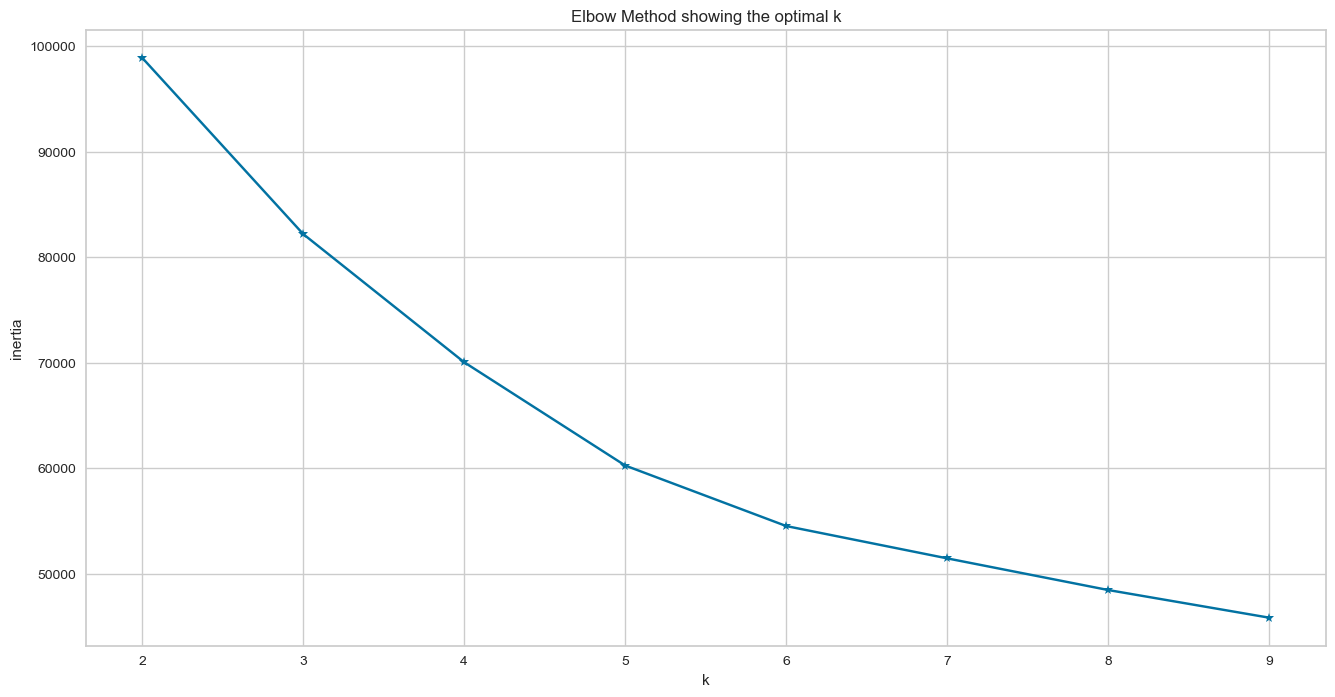

In [91]:
K = range(2, 10)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(16,8))
plt.plot(K, inertia, marker = '*')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

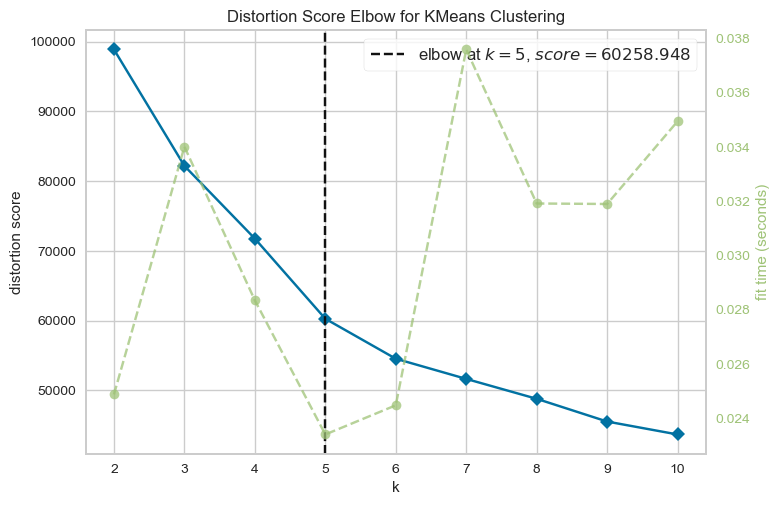

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [92]:
# Elbow method
kmeans_visualizer = KElbowVisualizer(KMeans(),K=(4,12))
kmeans_visualizer.fit(X_prep)
kmeans_visualizer.show()

In [93]:
# Clustering 4:
kmeans4 = KMeans(n_clusters=4, random_state=1234)
kmeans4.fit(X_prep)
kmeans4.fit_predict(X_prep)
labels4 = kmeans4.labels_

In [94]:
# Clustering 5:
kmeans5 = KMeans(n_clusters=5, random_state=1234)
kmeans5.fit(X_prep)
kmeans5.fit_predict(X_prep)
labels5 = kmeans5.labels_

In [95]:
# Clustering 6:
kmeans6 = KMeans(n_clusters=6, random_state=1234)
kmeans6.fit(X_prep)
kmeans6.fit_predict(X_prep)
labels6 = kmeans6.labels_

In [96]:
# Clustering 7:
kmeans7 = KMeans(n_clusters=7, random_state=1234)
kmeans7.fit(X_prep)
kmeans7.fit_predict(X_prep)
labels7 = kmeans7.labels_

In [97]:
print([kmeans4.inertia_,kmeans5.inertia_,kmeans6.inertia_,kmeans7.inertia_])
min([kmeans4.inertia_,kmeans5.inertia_,kmeans6.inertia_, kmeans7.inertia_])

[70040.50543397777, 60258.69430919249, 54526.95186339158, 51464.501673375504]


51464.501673375504

first run
[92579.70348946989, 80986.92914070253, 71338.4073004413, 65576.62415576629]

65576.62415576629
------
after removing "reviews_count"
[85706.03312031488, 75774.95873970508, 66214.27788717014, 60482.143737179846]

60482.143737179846
------
after removing "playtime"
[70042.15968303423, 60260.12145287158, 54528.221714493, 51172.853964116824]

51172.853964116824

The winner for less inertia is cluster=7

In [98]:
print(silhouette_score(X_prep, labels4))
print(silhouette_score(X_prep, labels5))
print(silhouette_score(X_prep, labels6))
print(silhouette_score(X_prep, labels7))

0.30183938646475306
0.30924984056475063
0.29935794229894036
0.2854873436205107


first run silhouette_score
0.28750905576426905
0.3001603301617199
0.3010667514381259
0.29293934258548043
------
after removing "reviews_count"
0.29442384687563117
0.30134069717939727
0.3030687071743616
0.29384260498802717
------
after removing "playtime"
0.3017835901167892
0.30913592473676266
0.2993117714484657
0.282864604821538

The winner for better silhouette score is cluster=5

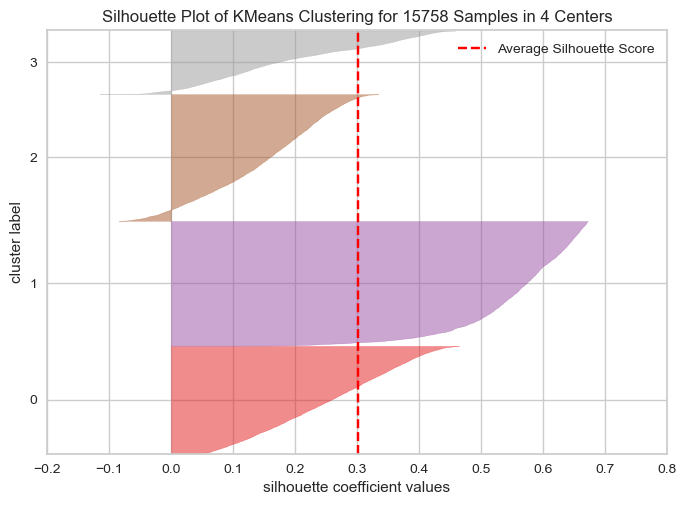

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 15758 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [99]:
# silhouette score method
sil_visualizer = SilhouetteVisualizer(KMeans(n_clusters=4, random_state=1234))
sil_visualizer.fit(X_prep)
sil_visualizer.show()

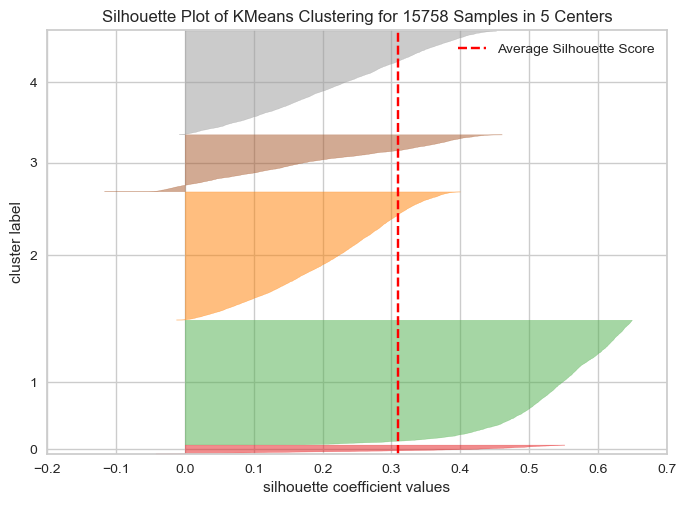

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 15758 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [100]:
# silhouette score method
sil_visualizer = SilhouetteVisualizer(KMeans(n_clusters=5, random_state=1234))
sil_visualizer.fit(X_prep)
sil_visualizer.show()

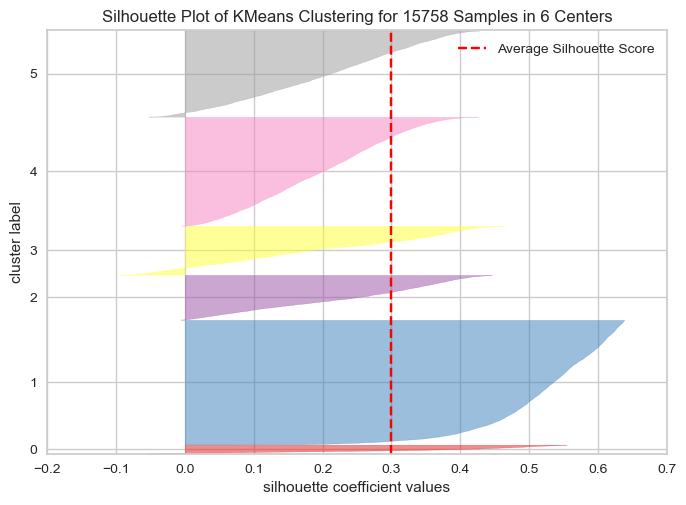

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 15758 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [101]:
# silhouette score method
sil_visualizer = SilhouetteVisualizer(KMeans(n_clusters=6, random_state=1234))
sil_visualizer.fit(X_prep)
sil_visualizer.show()

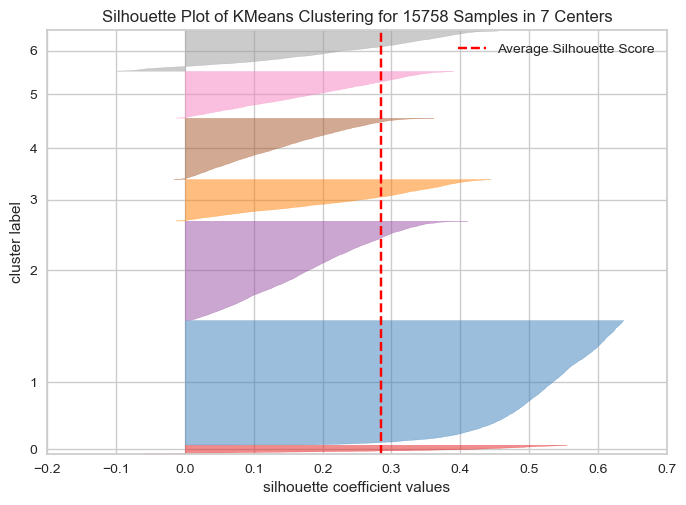

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 15758 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [102]:
# silhouette score method
sil_visualizer = SilhouetteVisualizer(KMeans(n_clusters=7, random_state=1234))
sil_visualizer.fit(X_prep)
sil_visualizer.show()

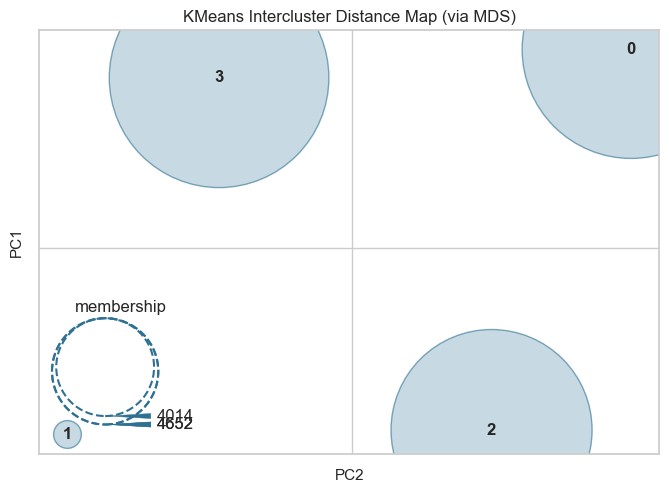

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [103]:
visualizer = InterclusterDistance(KMeans(n_clusters=4))
visualizer.fit(X_prep)
visualizer.show()

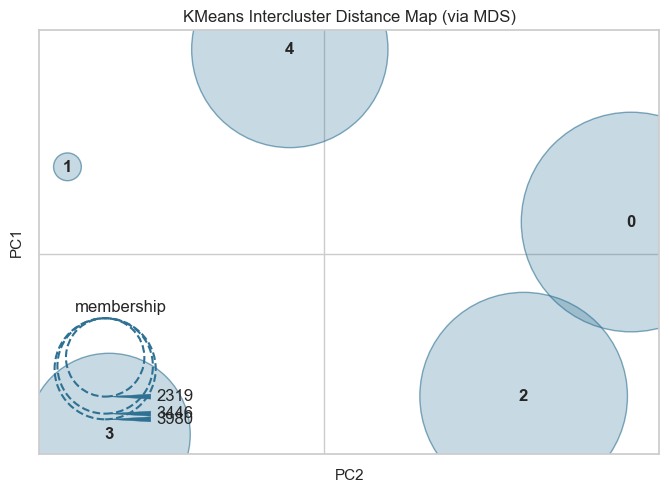

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [104]:
visualizer = InterclusterDistance(KMeans(n_clusters=5))
visualizer.fit(X_prep)
visualizer.show()

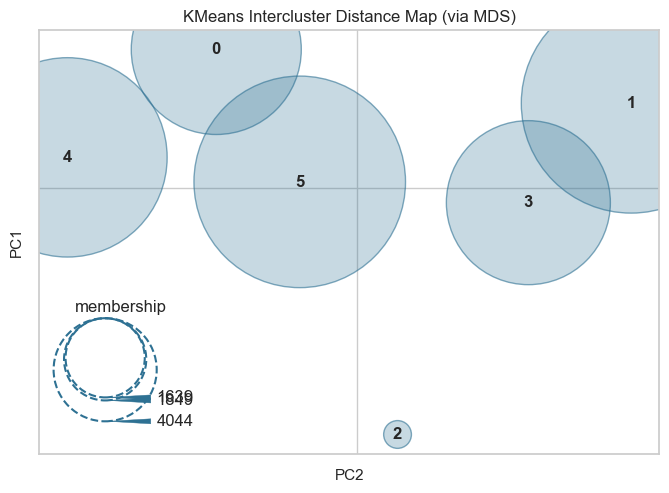

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [105]:
visualizer = InterclusterDistance(KMeans(n_clusters=6))
visualizer.fit(X_prep)
visualizer.show()

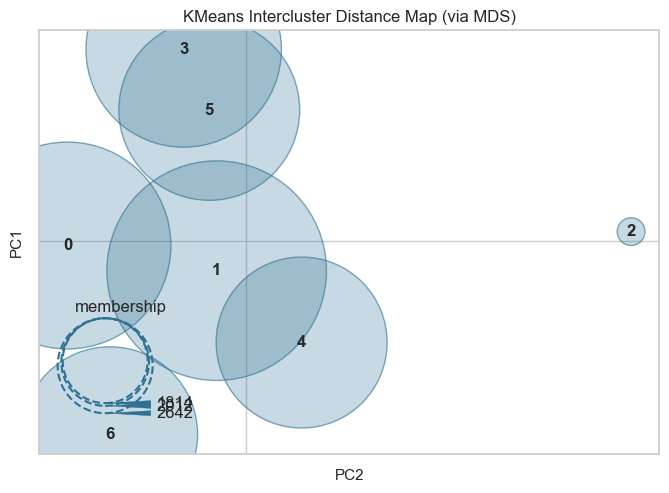

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [106]:
visualizer = InterclusterDistance(KMeans(n_clusters=7))
visualizer.fit(X_prep)
visualizer.show()

In [107]:
# Adding cluster label to dataframes
df_concat3["cluster"] = kmeans7.labels_
numericals["cluster"] = kmeans7.labels_

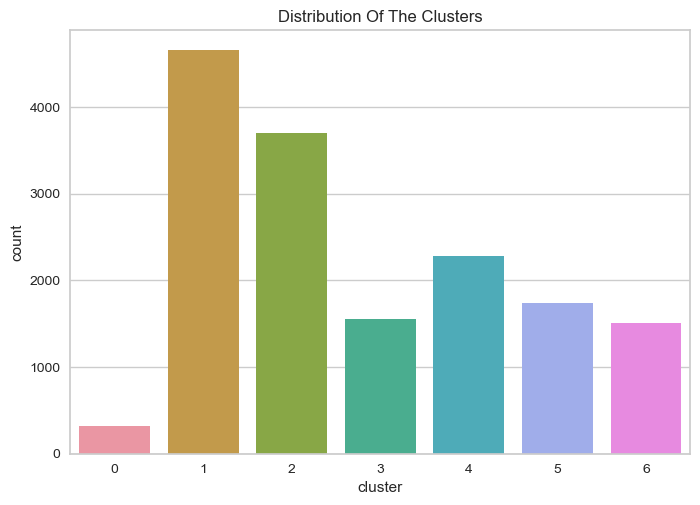

In [108]:
plot = sns.countplot(x=numericals["cluster"])
plot.set_title("Distribution Of The Clusters")
plt.show()

In [109]:
numericals

,rating,rating_top,ratings_count,suggestions_count,exceptional_,recommended_,meh_,skip_,cluster
0,4.47,5.0,6777.0,431.0,58.99,32.83,6.35,1.83,0
1,4.65,5.0,6489.0,675.0,77.15,16.12,4.20,2.53,0
2,4.61,5.0,5615.0,550.0,70.15,24.95,2.70,2.21,0
3,3.57,4.0,3443.0,587.0,16.10,46.81,25.91,11.18,0
4,4.05,4.0,3863.0,646.0,25.49,60.53,10.92,3.06,0
...,...,...,...,...,...,...,...,...,...
15753,3.83,4.0,5.0,374.0,0.00,0.00,0.00,0.00,1
15754,4.43,5.0,7.0,19.0,0.00,0.00,0.00,0.00,1
15755,4.11,4.0,7.0,111.0,0.00,0.00,0.00,0.00,1
15756,4.33,5.0,6.0,216.0,0.00,0.00,0.00,0.00,1


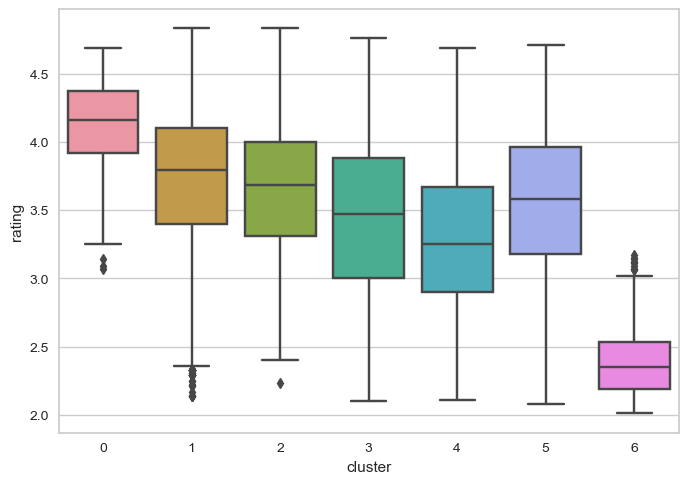

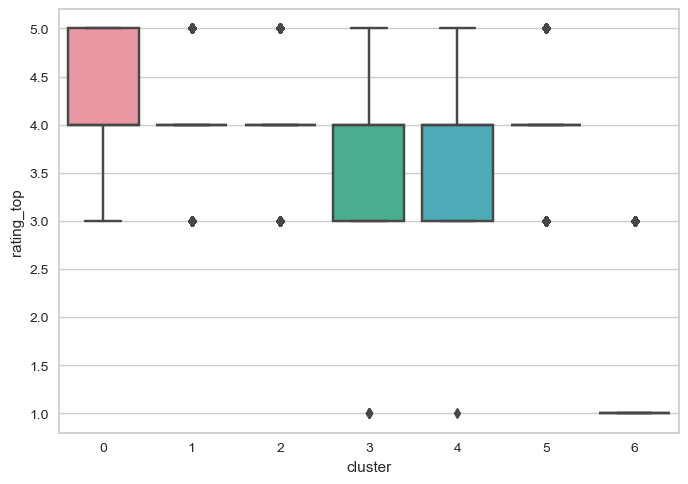

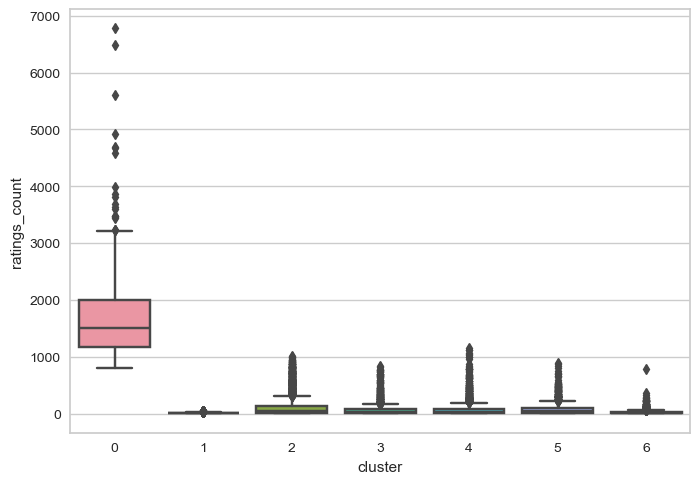

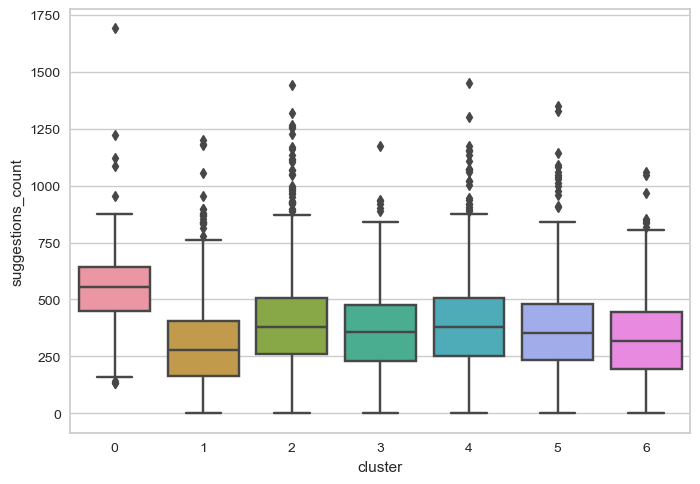

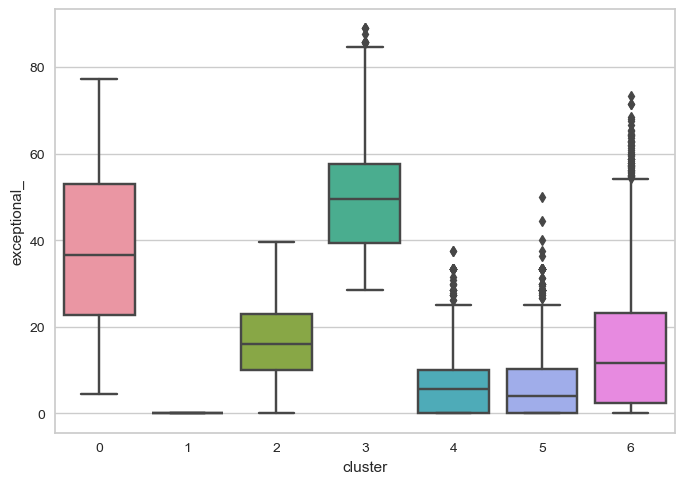

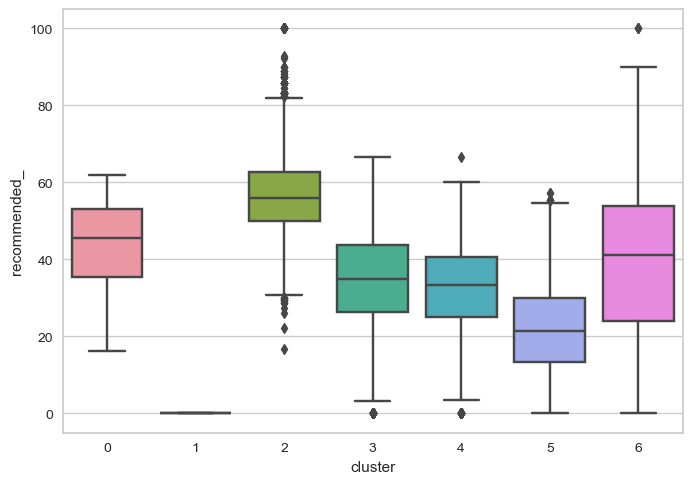

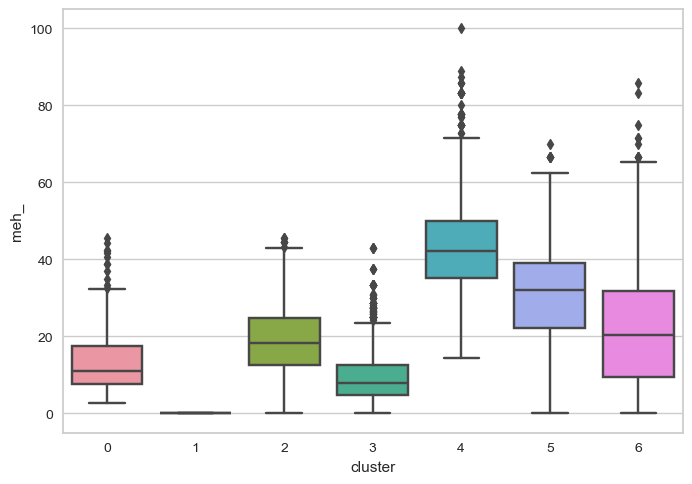

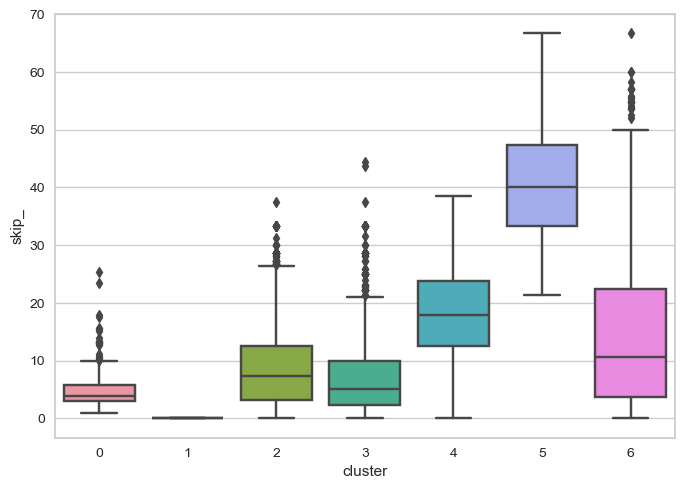

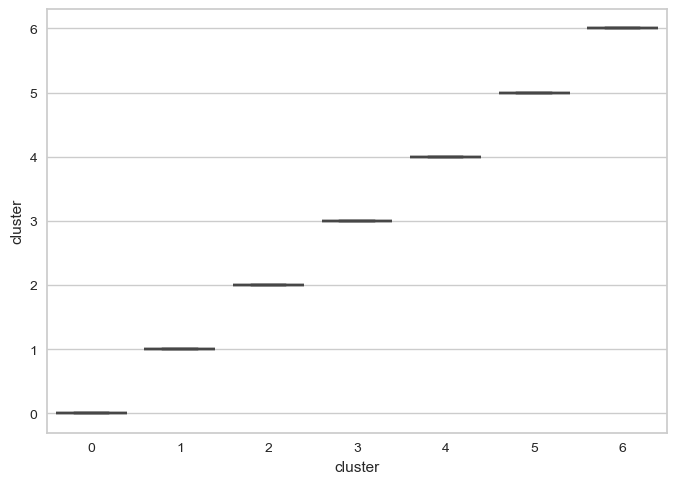

In [110]:
for col in numericals:
    sns.boxplot(x = 'cluster', y = col, data=numericals)
    plt.show()

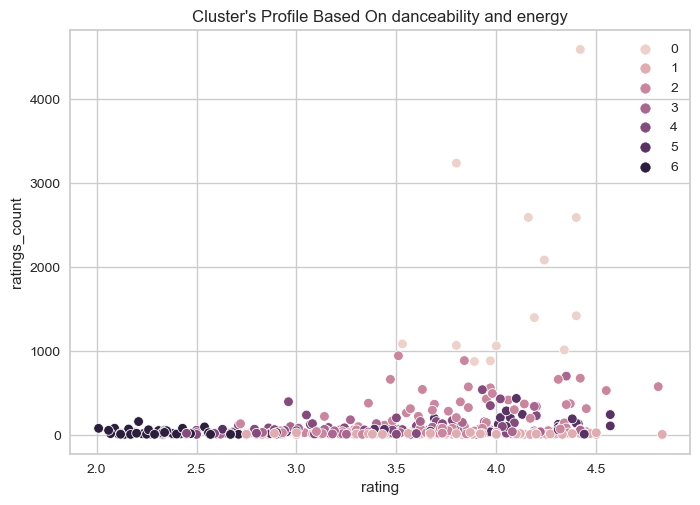

In [111]:
pl = sns.scatterplot(x="rating", y="ratings_count", hue="cluster", data =numericals.sample(500))
pl.set_title("Cluster's Profile Based On danceability and energy")
plt.legend()
plt.show()

In [112]:
# Export dataframe
df_concat3.to_csv("15759_games_clean_formatted_CLUSTERED.csv")

In [114]:
# Save kmeans model
joblib.dump(kmeans7, "15759_games_kmean7.sav")

['15759_games_kmean7.sav']